# Imports

In [2]:
!pip install nervaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip -q install ktrain requests

     |████████████████████████████████| 25.3 MB 1.2 MB/s 
     |████████████████████████████████| 981 kB 36.2 MB/s 
     |████████████████████████████████| 265 kB 67.0 MB/s 
     |████████████████████████████████| 3.8 MB 58.5 MB/s 
     |████████████████████████████████| 1.3 MB 52.0 MB/s 
     |████████████████████████████████| 468 kB 57.0 MB/s 
     |████████████████████████████████| 182 kB 55.1 MB/s 
     |████████████████████████████████| 7.6 MB 48.0 MB/s 
     |████████████████████████████████| 880 kB 45.3 MB/s 


In [4]:
!python -m spacy download pt_core_news_sm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.0 MB 14.3 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')


In [5]:
import pandas as pd
import numpy as np
import json
import pickle as pkl

import yaml

import ktrain 
from ktrain import text as txt

import uuid

import re
import spacy
from spacy.lang.pt.examples import sentences 
from spacy.training import offsets_to_biluo_tags

# Utils

In [6]:
nlp = spacy.load('pt_core_news_sm')

entidadesExtratoContrato = ['data_assinatura_contrato',
                            'partes_contratuais',
                            'natureza_despesa',
                            'nota_empenho',
                            'numero_contrato',
                            'objeto_contrato',
                            'processo_gdf',
                            'programa_trabalho',
                            'unidade_orcamentaria',
                            'valor_contrato',
                            'vigencia_contrato'
                            ]

def get_token_for_char(doc, char_idx):
    for i, token in enumerate(doc):
        if  token.idx <= char_idx <= token.idx+len(token.text):
            return token.idx,len(token.text)

def get_span(text, label, ent):
    span = {'label':label, 'start':0, 'end':0}
    doc = nlp(text)
    if ent in doc.text:
        t1 = get_token_for_char(doc,doc.text.index(ent))
        t2 = get_token_for_char(doc,doc.text.index(ent)+len(ent))
        span['start'] = t1[0]
        span['end'] = t2[0]+t2[1]
        #print(doc.text[span['start']:span['end']])
    return span

def entity_to_span(text, value, key):
    span_list = []
    e=0
    text = re.sub('\n', ' ', text)
    for entity in value:
        doc = nlp(text)
        ent = re.sub('\n', ' ', entity.replace(r'\n', '\n'))
        #print(text, '\n\t\t',key,'->', ent,'\n\n')
        #print(ent)
        span = {'label':key, 'start':0, 'end':0}
        #ent = entity[0]
        if ent in doc.text:
            #print(ent)
            #print(doc.text)
            t1 = get_token_for_char(doc,doc.text.index(ent))
            #print(doc.text.index(ent)+len(ent)-1)
            t2 = get_token_for_char(doc,doc.text.index(ent)+len(ent))
            span['start'] = t1[0]
            span['end'] = t2[0]+t2[1]
            #print(doc.text[span['start']:span['end']])
            if(span['start']!=0 and span['end']!=0):
                span_list.append((span['start']+e,span['end']+e,span['label']))
            e+=span['end']
            text = text[span['end']:]
    return span_list

# testando prediçoes coflitantes
# '(948, 958, 'data_assinatura_contrato')' and '(907, 1101, 'vigencia_contrato')'
def ajust_preds(text,preds,preds2):
    #print(preds)
    text = re.sub('\n', ' ', text)
    for p1 in preds:
        for p2 in preds:
            #print(p1,p2)
            if ((p2[0]<=p1[0] and p1[0]<=p2[1]) or (p2[0]<=p1[1] and p1[1]<=p2[1])) and p1 != p2:
                # print('p1:', p1)
                # print('p2:', p2)
                ent = text[p1[0]:p1[1]]
                label = p1[2]
                #print(ent)
                text_aux = text[p2[1]:]
                idx0 = p2[0]
                idx1 = p2[1]
                flag = 0
                # Procura no texto por outra ocorrencia
                while flag == 0:
                    flag = 1
                    span = get_span(text_aux,label,ent)
                    #print(span)
                    for p3 in preds:
                        # testa se esta occorencia ja está em alguma outra entidade, se sim continua procurando, se não encontrou a ocorrencia desejada
                        if ((p3[0]<=(span['start']+idx1)<=p3[1]) or (p3[0]<=(span['end']+idx1)<=p3[1])) and (span['start']!=0 and span['end']!=0):
                            #print('p3[0]:',p3[0])
                            #print('p3[1]:',p3[1])
                            flag = 0
                            text_aux = text[p3[1]:]
                            #print(text_aux)
                            idx0 = p3[0]
                            idx1 = p3[1]
                            # print(f"{span['start']} + {idx1} = {span['start']+idx1}")
                            # print(f"{span['end']} + {idx1} = {span['end']+idx1}")
                            #break
                # se achou um acorrencia que não faz parte de outra entidade, remove sua ocorrencia anterior e adiciona a nova
                if(span['start']!=0 and span['end']!=0):
                    #print('trocou p1: ', p1)
                    #print('por: ', (span['start']+idx1,span['end']+idx1,span['label']))
                    preds.remove(p1)
                    preds.append((span['start']+idx1,span['end']+idx1,span['label']))
                    return preds,preds2,0
                # se não achou nenhuma nova ocorrencia, devemos retirar a ocorrencia de maior tamanho, pois é provavel que essa esteja afetando a ocorrencia menor
                else:
                    ent = text[p2[0]:p2[1]]
                    label = p2[2]
                    #print(ent)
                    text_aux = text[p1[1]:]
                    idx0 = p1[0]
                    idx1 = p1[1]
                    flag = 0
                    while flag == 0:
                        flag = 1
                        span = get_span(text_aux,label,ent)
                        #print(span)
                        for p3 in preds:
                            # testa se esta occorencia ja está em alguma outra entidade, se sim continua procurando, se não encontrou a ocorrencia desejada
                            if ((p3[0]<=(span['start']+idx1)<=p3[1]) or (p3[0]<=(span['end']+idx1)<=p3[1])) and (span['start']!=0 and span['end']!=0):
                                #print('p3[0]:',p3[0])
                                #print('p3[1]:',p3[1])
                                flag = 0
                                text_aux = text[p3[1]:]
                                #print(text_aux)
                                idx0 = p3[0]
                                idx1 = p3[1]
                                # print(f"{span['start']} + {idx1} = {span['start']+idx1}")
                                # print(f"{span['end']} + {idx1} = {span['end']+idx1}")
                                #break
                    if(span['start']!=0 and span['end']!=0):
                        #print('trocou p1: ', p1)
                        #print('por: ', (span['start']+idx1,span['end']+idx1,span['label']))
                        preds.remove(p2)
                        preds.append((span['start']+idx1,span['end']+idx1,span['label']))
                        return preds,preds2,0
                    else:
                        #print('removeu p1: ', p1)
                        preds2.append(p1)
                        preds.remove(p1)
                        return preds,preds2,0
    return preds,preds2,1

def mix_final_preds(final_preds):
    for i in range(len(final_preds)):
        for j in range(i,len(final_preds)):
            for p1 in final_preds[i]:
                flag = 1
                for p2 in final_preds[j]:
                    if ((p2[0]<=p1[0]<=p2[1]) or (p2[0]<=p1[1]<=p2[1]) or (p1[0]<=p2[0]<=p1[1]) or (p1[0]<=p2[1]<=p1[1])):
                        flag = 0
                if flag==1:
                    final_preds[j].append(p1)
    return final_preds

def rec_ajust_preds(text,preds):
    final_preds = []
    preds2 = []
    teste = 0
    while teste != 1:
        preds,preds2, teste = ajust_preds(text,preds,preds2)
    if(preds2==[]):
        return [preds]
    else:
        final_preds.append(preds)
        for pred in rec_ajust_preds(text,preds2):
            final_preds.append(pred)
        # Junta as predições que não sobresaeem uma da outra
        return mix_final_preds(final_preds)

def get_list_spans(text,labels_dict):
    #labels_dict = yaml.safe_load(labels_dict)
    lista = []
    for key, value in labels_dict.items():
        if key not in entidadesExtratoContrato:
          continue
        #pred = ajust_preds(text,entity_to_span(text,value,key))
        pred = entity_to_span(text,value,key)
        for i in pred:
            lista.append(i)
    #print(lista)
    return rec_ajust_preds(text,lista)

In [7]:
def tokenize(texto,labels):
    if isinstance(labels, str):
        labels = yaml.safe_load(re.sub('\n', ' ', labels.replace(r'\n', '\n')))
        
    nlp = spacy.load('pt_core_news_sm')
    preds = get_list_spans(texto,labels)

    conll=''
    for pred in preds:

        text = re.sub('\n', ' ', texto)
        doc = nlp(text)

        tags = offsets_to_biluo_tags(doc, pred)

        for i in range(len(doc)):
            if tags[i][0] == 'U':
                conll += doc[i].text + ' ' + 'B' + tags[i][1:] + '\n'
            elif tags[i][0] == 'L':
                conll += doc[i].text + ' ' + 'I' + tags[i][1:] + '\n'
            else:
                conll += doc[i].text + ' ' + tags[i] + '\n'
              
        conll+='\n'

    return conll

In [8]:
# Função que gera string no formato Conll a partir das predições dos modelos
def get_conll_conc(pred):
  conll_conc = ""
  for i, tupla in enumerate(pred):
      txt,ent = tupla[0],tupla[1]
      if ent =='O':
        conll_conc += txt + ' O\n'
      else:
        if(i!=0 and pred[i-1][1]==ent):
          conll_conc += txt + ' '+ ent +'\n'
        else:
          conll_conc += txt + ' '+ ent +'\n'
  return conll_conc+'\n'

In [9]:
# função que trasnforma as prediçõe dos modelos ktrain em dicionarios para facilitar a comparação sem depender de tokenizações
def get_entities_from_prediction(predictions):
    lista = []
    cont = 0
    for pred in predictions:
        ents_dit = {}
        i=0
        while (i < len(pred)):
            txt,ent = pred[i][0],pred[i][1]
            if ent !='O':
                aux_txt = txt
                while(len(pred) > i+1 and pred[i+1][1] != 'O'):
                    if(pred[i+1][1][2:] == ent[2:]):
                        aux_txt += ' ' + pred[i+1][0]
                        i+=1
                    else:
                        break
                if(ent[2:] in ents_dit):
                    ents_dit[ent[2:]].append(aux_txt)
                else:
                    ents_dit[ent[2:]] = [aux_txt]
            i+=1
        lista.append(ents_dit)
        cont+=1
    return lista

# Carregando dados

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
# import gdown

# url = 'https://drive.google.com/drive/folders/1AJitYBCAc-vI5kgcAGEVV5oD4q9EmVoZ?usp=sharing'

# gdown.download_folder(url)

In [12]:
#CONLL BASE COM 783 atos pelo GPT Mais os atos combinados em usa porcentagems
VAL_DATA = "/content/drive/MyDrive/tccF/val_conll.conll"
BASE_DATA_10 = "/content/drive/MyDrive/Conll_IT/Combined/conll_110.conll"
BASE_DATA_20 = "/content/drive/MyDrive/Conll_IT/Combined/conll_120.conll"
BASE_DATA_30 = "/content/drive/MyDrive/Conll_IT/Combined/conll_130.conll"
BASE_DATA_40 = "/content/drive/MyDrive/Conll_IT/Combined/conll_140.conll"
BASE_DATA_50 = "/content/drive/MyDrive/Conll_IT/Combined/conll_150.conll"
BASE_DATA_60 = "/content/drive/MyDrive/Conll_IT/Combined/conll_160.conll"
BASE_DATA_70 = "/content/drive/MyDrive/Conll_IT/Combined/conll_170.conll"
BASE_DATA_80 = "/content/drive/MyDrive/Conll_IT/Combined/conll_180.conll"
BASE_DATA_90 = "/content/drive/MyDrive/Conll_IT/Combined/conll_190.conll"
BASE_DATA_100 = "/content/drive/MyDrive/Conll_IT/Combined/conll_200.conll"

In [13]:
# Dataframe que servirá para o treinamento iterativo dos modelos
# df_test = pd.read_csv('/content/tccF/df_test.csv')
df_test = pd.read_csv('/content/drive/MyDrive/tccF/df_test.csv')
df_test.drop('Unnamed: 0', axis=1, inplace=True)
df_test

,id,id_ato,texto,label
0,444,631-R47,EXTRATO DO CONTRATO Nº 43338/2021 Processo: 04...,{'partes_contratuais': ['INSTITUTO DE ASSIST. ...
1,51,634-R93,EXTRATO DE CONTRATO Nº 45384/2021 Processo: 00...,"{'numero_contrato': ['45384/2021', '45384/2021..."
2,140,628-R103,EXTRATO DO CONTRATO Nº 204/2021 Processo: 0015...,"{'partes_contratuais': ['DF/SECEC/FAC', 'WAYNE..."
3,242,630-R76,EXTRATO DO CONTRATO DE PRESTAÇÃO DE SERVIÇO Nº...,"{'natureza_despesa': ['339039'], 'numero_contr..."
4,624,671-R49,EXTRATO DE CONTRATO DE PATROCÍNIO Extrato do C...,{'partes_contratuais': ['Companhia de Planejam...
...,...,...,...,...
375,273,637-R130,EXTRATO DO CONTRATO Nº 045005/2021 Processo: 0...,{'partes_contratuais': ['SECRETARIA DE ESTADO ...
376,594,626-R141,EXTRATO DO CONTRATO PARA AQUISIÇÃO DE BENS PEL...,"{'natureza_despesa': ['449052'], 'partes_contr..."
377,704,639-R143,EXTRATO DO CONTRATO Nº 43.980/2021 Processo: 0...,{'partes_contratuais': ['INSTITUTO DE ASSIST. ...
378,436,631-R35,EXTRATO DO CONTRATO Nº 42705/2021 Processo: 04...,{'partes_contratuais': ['INSTITUTO DE ASSIST. ...


In [14]:
print(len(df_test))

380


In [15]:
# definindo as samples (textos dos atos) em que serão aplicados os modelo
test_data = [ [df_test['id'][j],df_test['texto'][j],df_test['label'][j]]  for j in range(len(list(df_test['id']))) ]
samples = [test_data[i][1] for i in range(len(test_data))]
print(len(samples))

380


In [16]:
samples[0]

'EXTRATO DO CONTRATO Nº 43338/2021 Processo: 04001-0000000210/2021-91. Das Partes: INSTITUTO DE ASSIST. À SAÚDE DOS SERV. DO DF-INAS na qualidade de CONTRATANTE, COOP. BRASILIENSE DOS ANESTESIOLOGISTAS LTDA na qualidade de CONTRATADA. Do Objeto: CREDECIAMENTO DE PESSOAS JURIDICAS PARA PRESTAÇÃO DE SERVIÇOS DE SAÚDE AOS BENEFICIÁRIOS DO PLANO DE ASSISTÊNCIA SUPLEMENTAR À SAÚDE - GDF-SAÚDE-DF, COMPREENDENDO ASSISTÊNCIA MÉDICA E SERVIÇOS AUXILIARES DE DIAGNÓSTICO E TERAPIA; CONFORME CONTRATO. DO VALOR: R$ 55,843.60 (cinquenta e cinco mil e oitocentos e quarenta e três reais e sessenta centavos) e correrá à conta de dotações orçamentárias consignadas no orçamento corrente - Lei Orçamentária Anual. DA DOTAÇÃO ORÇAMENTÁRIA: A despesa correrá à conta da seguinte Dotação Orçamentária: DOTAÇÃO ORÇAMENTÁRIA: UO:19212; PROGRAMA DE TRABALHO: 10122620361957, FONTE DE RECURSO: 220000000; UG: 140202; GESTÃO: 14202; EMPENHO 2021NE0/0129, DATADO DE: 21/07/2021, VALOR DO EMPENHO: R$ 55,843.60 (cinquenta

# Treinando Modelos

## 10

In [ ]:
print('\n***************************************')
print('TREINANDO ....')
print('***************************************\n')

(trn, val, preproc) = txt.entities_from_conll2003(BASE_DATA_10,
                                                  val_filepath = VAL_DATA,
                                                  verbose=0)
# INSTANCIANDO MODELO
model = txt.sequence_tagger(
    'bilstm-transformer', preproc, verbose=0,
    transformer_model='pierreguillou/bert-base-cased-pt-lenerbr')

# INSTANCIANDO LEARNER
learner = ktrain.get_learner(
    model, train_data=trn,
    val_data=val, batch_size=128)

# TEINANDO MODELO
learner.autofit(0.01,epochs=10)

# INSTANCIANDO PREDITOR
predictor = ktrain.get_predictor(
    learner.model, preproc)



***************************************
TREINANDO ....
***************************************



Downloading:   0%|          | 0.00/893 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/530 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/205k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/428k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.8/dist-packages/ktrain/text/preprocessor.py:1473: UserWarning: Could not load a Tensorflow version of model. (If this worked before, it might be an out-of-memory issue.) Attempting to download/load PyTorch version as TensorFlow model using from_pt=True. You will need PyTorch installed for this.
  warnings.warn(


Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]



begin training using triangular learning rate policy with max lr of 0.01...
preparing training data ...done.
preparing validation data ...done.
Epoch 1/10
9/9 [==============================] - 80s 8s/step - loss: 0.8454 - val_loss: 0.6939
Epoch 2/10
9/9 [==============================] - 69s 8s/step - loss: 0.4509 - val_loss: 0.4951
Epoch 3/10
9/9 [==============================] - 69s 8s/step - loss: 0.3682 - val_loss: 0.4020
Epoch 4/10
9/9 [==============================] - 69s 8s/step - loss: 0.3203 - val_loss: 0.3208
Epoch 5/10
9/9 [==============================] - 69s 8s/step - loss: 0.2882 - val_loss: 0.2998
Epoch 6/10
9/9 [==============================] - 69s 8s/step - loss: 0.2658 - val_loss: 0.2728
Epoch 7/10
9/9 [==============================] - 69s 8s/step - loss: 0.2500 - val_loss: 0.2610
Epoch 8/10
9/9 [==============================] - 69s 8s/step - loss: 0.2303 - val_loss: 0.2705
Epoch 9/10
9/9 [==============================] - 69s 8s/step - loss: 0.2205 - val_los

In [ ]:
dict10 = get_entities_from_prediction(predictor.predict(samples))

In [ ]:
learner.validate()

   F1:  43.58
                          precision    recall  f1-score   support

data_assinatura_contrato       0.74      0.61      0.67       171
        natureza_despesa       0.94      0.52      0.67       262
            nota_empenho       0.95      0.66      0.78       328
         numero_contrato       0.94      0.80      0.86       458
         objeto_contrato       0.07      0.32      0.11       385
      partes_contratuais       0.17      0.23      0.19       741
            processo_gdf       0.79      0.81      0.80       411
       programa_trabalho       0.77      0.52      0.62       345
    unidade_orcamentaria       0.94      0.41      0.57       287
          valor_contrato       0.93      0.61      0.73       362
       vigencia_contrato       0.10      0.14      0.11       309

               micro avg       0.39      0.50      0.44      4059
               macro avg       0.67      0.51      0.56      4059
            weighted avg       0.61      0.50      0.53     

0.43584742089293455

In [ ]:
with open("/content/drive/MyDrive/Conll_IT/Results/bertlener/dict_bertlener10.pkl", "wb") as f:
    pkl.dump(dict10, f)

## 20

In [ ]:
print('\n***************************************')
print('TREINANDO ....')
print('***************************************\n')

(trn, val, preproc) = txt.entities_from_conll2003(BASE_DATA_20,
                                                  val_filepath = VAL_DATA,
                                                  verbose=0)
# INSTANCIANDO MODELO
model = txt.sequence_tagger(
    'bilstm-transformer', preproc, verbose=0,
    transformer_model='pierreguillou/bert-base-cased-pt-lenerbr')

# INSTANCIANDO LEARNER
learner = ktrain.get_learner(
    model, train_data=trn,
    val_data=val, batch_size=128)

# TEINANDO MODELO
learner.autofit(0.01,epochs=10)

# INSTANCIANDO PREDITOR
predictor = ktrain.get_predictor(
    learner.model, preproc)



***************************************
TREINANDO ....
***************************************



/usr/local/lib/python3.8/dist-packages/ktrain/text/preprocessor.py:1473: UserWarning: Could not load a Tensorflow version of model. (If this worked before, it might be an out-of-memory issue.) Attempting to download/load PyTorch version as TensorFlow model using from_pt=True. You will need PyTorch installed for this.
  warnings.warn(




begin training using triangular learning rate policy with max lr of 0.01...
preparing training data ...done.
preparing validation data ...done.
Epoch 1/10
10/10 [==============================] - 84s 7s/step - loss: 0.7892 - val_loss: 0.5840
Epoch 2/10
10/10 [==============================] - 73s 7s/step - loss: 0.4154 - val_loss: 0.4152
Epoch 3/10
10/10 [==============================] - 73s 7s/step - loss: 0.3424 - val_loss: 0.3440
Epoch 4/10
10/10 [==============================] - 73s 7s/step - loss: 0.2978 - val_loss: 0.2955
Epoch 5/10
10/10 [==============================] - 73s 7s/step - loss: 0.2716 - val_loss: 0.2380
Epoch 6/10
10/10 [==============================] - 73s 7s/step - loss: 0.2437 - val_loss: 0.2614
Epoch 7/10
10/10 [==============================] - 73s 8s/step - loss: 0.2311 - val_loss: 0.2217
Epoch 8/10
10/10 [==============================] - 73s 7s/step - loss: 0.2152 - val_loss: 0.2350
Epoch 9/10
10/10 [==============================] - 73s 7s/step - loss

In [ ]:
dict20 = get_entities_from_prediction(predictor.predict(samples))

In [ ]:
learner.validate()

   F1:  44.53
                          precision    recall  f1-score   support

data_assinatura_contrato       0.79      0.41      0.54       171
        natureza_despesa       0.97      0.65      0.78       262
            nota_empenho       0.98      0.66      0.79       328
         numero_contrato       0.96      0.71      0.82       458
         objeto_contrato       0.13      0.39      0.20       385
      partes_contratuais       0.13      0.17      0.15       741
            processo_gdf       0.75      0.77      0.76       411
       programa_trabalho       0.79      0.52      0.63       345
    unidade_orcamentaria       0.88      0.59      0.70       287
          valor_contrato       0.93      0.54      0.68       362
       vigencia_contrato       0.03      0.06      0.04       309

               micro avg       0.42      0.48      0.45      4059
               macro avg       0.67      0.50      0.55      4059
            weighted avg       0.61      0.48      0.52     

0.4452588181401741

In [ ]:
with open("/content/drive/MyDrive/Conll_IT/Results/bertlener/dict_bertlener20.pkl", "wb") as f:
    pkl.dump(dict20, f)

## 30

In [ ]:
print('\n***************************************')
print('TREINANDO ....')
print('***************************************\n')

(trn, val, preproc) = txt.entities_from_conll2003(BASE_DATA_30,
                                                  val_filepath = VAL_DATA,
                                                  verbose=0)
# INSTANCIANDO MODELO
model = txt.sequence_tagger(
    'bilstm-transformer', preproc, verbose=0,
    transformer_model='pierreguillou/bert-base-cased-pt-lenerbr')

# INSTANCIANDO LEARNER
learner = ktrain.get_learner(
    model, train_data=trn,
    val_data=val, batch_size=128)

# TEINANDO MODELO
learner.autofit(0.01,epochs=10)

# INSTANCIANDO PREDITOR
predictor = ktrain.get_predictor(
    learner.model, preproc)



***************************************
TREINANDO ....
***************************************



/usr/local/lib/python3.8/dist-packages/ktrain/text/preprocessor.py:1473: UserWarning: Could not load a Tensorflow version of model. (If this worked before, it might be an out-of-memory issue.) Attempting to download/load PyTorch version as TensorFlow model using from_pt=True. You will need PyTorch installed for this.
  warnings.warn(




begin training using triangular learning rate policy with max lr of 0.01...
preparing training data ...done.
preparing validation data ...done.
Epoch 1/10
11/11 [==============================] - 88s 7s/step - loss: 0.7806 - val_loss: 0.5371
Epoch 2/10
11/11 [==============================] - 77s 7s/step - loss: 0.3995 - val_loss: 0.3862
Epoch 3/10
11/11 [==============================] - 77s 7s/step - loss: 0.3272 - val_loss: 0.3142
Epoch 4/10
11/11 [==============================] - 77s 7s/step - loss: 0.2851 - val_loss: 0.2833
Epoch 5/10
11/11 [==============================] - 77s 7s/step - loss: 0.2603 - val_loss: 0.2753
Epoch 6/10
11/11 [==============================] - 77s 7s/step - loss: 0.2428 - val_loss: 0.2473
Epoch 7/10
11/11 [==============================] - 77s 7s/step - loss: 0.2205 - val_loss: 0.2246
Epoch 8/10
11/11 [==============================] - 77s 7s/step - loss: 0.2107 - val_loss: 0.2250
Epoch 9/10
11/11 [==============================] - 77s 7s/step - loss

In [ ]:
dict30 = get_entities_from_prediction(predictor.predict(samples))

In [ ]:
learner.validate()

In [ ]:
with open("/content/drive/MyDrive/Conll_IT/Results/bertlener/dict_bertlener30.pkl", "wb") as f:
    pkl.dump(dict30, f)

## 40

In [ ]:
print('\n***************************************')
print('TREINANDO ....')
print('***************************************\n')

(trn, val, preproc) = txt.entities_from_conll2003(BASE_DATA_40,
                                                  val_filepath = VAL_DATA,
                                                  verbose=0)
# INSTANCIANDO MODELO
model = txt.sequence_tagger(
    'bilstm-transformer', preproc, verbose=0,
    transformer_model='pierreguillou/bert-base-cased-pt-lenerbr')

# INSTANCIANDO LEARNER
learner = ktrain.get_learner(
    model, train_data=trn,
    val_data=val, batch_size=128)

# TEINANDO MODELO
learner.autofit(0.01,epochs=10)

# INSTANCIANDO PREDITOR
predictor = ktrain.get_predictor(
    learner.model, preproc)


In [ ]:
dict40 = get_entities_from_prediction(predictor.predict(samples))

In [ ]:
learner.validate()

In [ ]:
with open("/content/drive/MyDrive/Conll_IT/Results/bertlener/dict_bertlener40.pkl", "wb") as f:
    pkl.dump(dict40, f)

## 50

In [ ]:
print('\n***************************************')
print('TREINANDO ....')
print('***************************************\n')

(trn, val, preproc) = txt.entities_from_conll2003(BASE_DATA_50,
                                                  val_filepath = VAL_DATA,
                                                  verbose=0)
# INSTANCIANDO MODELO
model = txt.sequence_tagger(
    'bilstm-transformer', preproc, verbose=0,
    transformer_model='pierreguillou/bert-base-cased-pt-lenerbr')

# INSTANCIANDO LEARNER
learner = ktrain.get_learner(
    model, train_data=trn,
    val_data=val, batch_size=128)

# TEINANDO MODELO
learner.autofit(0.01,epochs=10)

# INSTANCIANDO PREDITOR
predictor = ktrain.get_predictor(
    learner.model, preproc)



***************************************
TREINANDO ....
***************************************



/usr/local/lib/python3.8/dist-packages/ktrain/text/preprocessor.py:1473: UserWarning: Could not load a Tensorflow version of model. (If this worked before, it might be an out-of-memory issue.) Attempting to download/load PyTorch version as TensorFlow model using from_pt=True. You will need PyTorch installed for this.
  warnings.warn(




begin training using triangular learning rate policy with max lr of 0.01...
preparing training data ...done.
preparing validation data ...done.
Epoch 1/10
12/12 [==============================] - 95s 7s/step - loss: 0.7531 - val_loss: 0.5393
Epoch 2/10
12/12 [==============================] - 85s 7s/step - loss: 0.3688 - val_loss: 0.3507
Epoch 3/10
12/12 [==============================] - 84s 7s/step - loss: 0.3040 - val_loss: 0.2917
Epoch 4/10
12/12 [==============================] - 84s 7s/step - loss: 0.2643 - val_loss: 0.2241
Epoch 5/10
12/12 [==============================] - 85s 7s/step - loss: 0.2379 - val_loss: 0.2368
Epoch 6/10
12/12 [==============================] - 85s 7s/step - loss: 0.2186 - val_loss: 0.2456
Epoch 7/10
12/12 [==============================] - 85s 7s/step - loss: 0.2064 - val_loss: 0.2225
Epoch 8/10
12/12 [==============================] - 85s 7s/step - loss: 0.1961 - val_loss: 0.1948
Epoch 9/10
12/12 [==============================] - 84s 7s/step - loss

In [ ]:
dict50 = get_entities_from_prediction(predictor.predict(samples))

In [ ]:
learner.validate()

   F1:  52.08
                          precision    recall  f1-score   support

data_assinatura_contrato       0.84      0.59      0.69       171
        natureza_despesa       0.95      0.78      0.86       262
            nota_empenho       0.98      0.70      0.82       328
         numero_contrato       0.95      0.76      0.84       458
         objeto_contrato       0.14      0.42      0.21       385
      partes_contratuais       0.19      0.28      0.22       741
            processo_gdf       0.84      0.89      0.86       411
       programa_trabalho       0.79      0.59      0.67       345
    unidade_orcamentaria       0.97      0.70      0.81       287
          valor_contrato       0.92      0.73      0.81       362
       vigencia_contrato       0.07      0.11      0.08       309

               micro avg       0.48      0.57      0.52      4059
               macro avg       0.69      0.59      0.63      4059
            weighted avg       0.64      0.57      0.59     

0.5208380265825637

In [ ]:
with open("/content/drive/MyDrive/Conll_IT/Results/bertlener/dict_bertlener50.pkl", "wb") as f:
    pkl.dump(dict50, f)

## 60

In [ ]:
print('\n***************************************')
print('TREINANDO ....')
print('***************************************\n')

(trn, val, preproc) = txt.entities_from_conll2003(BASE_DATA_60,
                                                  val_filepath = VAL_DATA,
                                                  verbose=0)
# INSTANCIANDO MODELO
model = txt.sequence_tagger(
    'bilstm-transformer', preproc, verbose=0,
    transformer_model='pierreguillou/bert-base-cased-pt-lenerbr')

# INSTANCIANDO LEARNER
learner = ktrain.get_learner(
    model, train_data=trn,
    val_data=val, batch_size=128)

# TEINANDO MODELO
learner.autofit(0.01,epochs=10)

# INSTANCIANDO PREDITOR
predictor = ktrain.get_predictor(
    learner.model, preproc)



***************************************
TREINANDO ....
***************************************



/usr/local/lib/python3.8/dist-packages/ktrain/text/preprocessor.py:1473: UserWarning: Could not load a Tensorflow version of model. (If this worked before, it might be an out-of-memory issue.) Attempting to download/load PyTorch version as TensorFlow model using from_pt=True. You will need PyTorch installed for this.
  warnings.warn(




begin training using triangular learning rate policy with max lr of 0.01...
preparing training data ...done.
preparing validation data ...done.
Epoch 1/10
13/13 [==============================] - 100s 7s/step - loss: 0.7037 - val_loss: 0.4338
Epoch 2/10
13/13 [==============================] - 89s 7s/step - loss: 0.3343 - val_loss: 0.2927
Epoch 3/10
13/13 [==============================] - 89s 7s/step - loss: 0.2781 - val_loss: 0.2521
Epoch 4/10
13/13 [==============================] - 89s 7s/step - loss: 0.2495 - val_loss: 0.2136
Epoch 5/10
13/13 [==============================] - 89s 7s/step - loss: 0.2250 - val_loss: 0.2047
Epoch 6/10
13/13 [==============================] - 89s 7s/step - loss: 0.2101 - val_loss: 0.2253
Epoch 7/10
13/13 [==============================] - 89s 7s/step - loss: 0.2042 - val_loss: 0.2157
Epoch 8/10
13/13 [==============================] - 88s 7s/step - loss: 0.1929 - val_loss: 0.2429
Epoch 9/10
13/13 [==============================] - 89s 7s/step - los

In [ ]:
dict60 = get_entities_from_prediction(predictor.predict(samples))

In [ ]:
learner.validate()

   F1:  61.56
                          precision    recall  f1-score   support

data_assinatura_contrato       0.92      0.71      0.81       171
        natureza_despesa       0.96      0.83      0.89       262
            nota_empenho       0.97      0.88      0.92       328
         numero_contrato       0.94      0.84      0.88       458
         objeto_contrato       0.18      0.52      0.27       385
      partes_contratuais       0.22      0.32      0.26       741
            processo_gdf       0.87      0.92      0.89       411
       programa_trabalho       0.90      0.74      0.81       345
    unidade_orcamentaria       0.97      0.82      0.89       287
          valor_contrato       0.90      0.87      0.88       362
       vigencia_contrato       0.35      0.49      0.41       309

               micro avg       0.56      0.69      0.62      4059
               macro avg       0.74      0.72      0.72      4059
            weighted avg       0.68      0.69      0.67     

0.6155715074544451

In [ ]:
with open("/content/drive/MyDrive/Conll_IT/Results/bertlener/dict_bertlener60.pkl", "wb") as f:
    pkl.dump(dict60, f)

## 70

In [ ]:
print('\n***************************************')
print('TREINANDO ....')
print('***************************************\n')

(trn, val, preproc) = txt.entities_from_conll2003(BASE_DATA_70,
                                                  val_filepath = VAL_DATA,
                                                  verbose=0)
# INSTANCIANDO MODELO
model = txt.sequence_tagger(
    'bilstm-transformer', preproc, verbose=0,
    transformer_model='pierreguillou/bert-base-cased-pt-lenerbr')

# INSTANCIANDO LEARNER
learner = ktrain.get_learner(
    model, train_data=trn,
    val_data=val, batch_size=128)

# TEINANDO MODELO
learner.autofit(0.01,epochs=10)

# INSTANCIANDO PREDITOR
predictor = ktrain.get_predictor(
    learner.model, preproc)



***************************************
TREINANDO ....
***************************************



/usr/local/lib/python3.8/dist-packages/ktrain/text/preprocessor.py:1473: UserWarning: Could not load a Tensorflow version of model. (If this worked before, it might be an out-of-memory issue.) Attempting to download/load PyTorch version as TensorFlow model using from_pt=True. You will need PyTorch installed for this.
  warnings.warn(




begin training using triangular learning rate policy with max lr of 0.01...
preparing training data ...done.
preparing validation data ...done.
Epoch 1/10
14/14 [==============================] - 104s 7s/step - loss: 0.6756 - val_loss: 0.5055
Epoch 2/10
14/14 [==============================] - 92s 7s/step - loss: 0.3441 - val_loss: 0.3053
Epoch 3/10
14/14 [==============================] - 93s 7s/step - loss: 0.2702 - val_loss: 0.2467
Epoch 4/10
14/14 [==============================] - 92s 7s/step - loss: 0.2480 - val_loss: 0.2216
Epoch 5/10
14/14 [==============================] - 93s 7s/step - loss: 0.2278 - val_loss: 0.1985
Epoch 6/10
14/14 [==============================] - 93s 7s/step - loss: 0.2198 - val_loss: 0.1863
Epoch 7/10
14/14 [==============================] - 92s 7s/step - loss: 0.2048 - val_loss: 0.2083
Epoch 8/10
14/14 [==============================] - 93s 7s/step - loss: 0.2052 - val_loss: 0.2204
Epoch 9/10
14/14 [==============================] - 93s 7s/step - los

In [ ]:
dict70 = get_entities_from_prediction(predictor.predict(samples))

In [ ]:
learner.validate()

   F1:  63.87
                          precision    recall  f1-score   support

data_assinatura_contrato       0.70      0.74      0.72       171
        natureza_despesa       0.94      0.89      0.91       262
            nota_empenho       0.97      0.96      0.97       328
         numero_contrato       0.87      0.93      0.90       458
         objeto_contrato       0.20      0.53      0.29       385
      partes_contratuais       0.36      0.49      0.41       741
            processo_gdf       0.85      0.95      0.90       411
       programa_trabalho       0.80      0.77      0.78       345
    unidade_orcamentaria       0.79      0.93      0.86       287
          valor_contrato       0.76      0.94      0.84       362
       vigencia_contrato       0.20      0.48      0.29       309

               micro avg       0.55      0.76      0.64      4059
               macro avg       0.68      0.78      0.71      4059
            weighted avg       0.64      0.76      0.69     

0.6387391124014931

In [ ]:
with open("/content/drive/MyDrive/Conll_IT/Results/bertlener/dict_bertlener70.pkl", "wb") as f:
    pkl.dump(dict70, f)

## 80

In [ ]:
print('\n***************************************')
print('TREINANDO ....')
print('***************************************\n')

(trn, val, preproc) = txt.entities_from_conll2003(BASE_DATA_80,
                                                  val_filepath = VAL_DATA,
                                                  verbose=0)
# INSTANCIANDO MODELO
model = txt.sequence_tagger(
    'bilstm-transformer', preproc, verbose=0,
    transformer_model='pierreguillou/bert-base-cased-pt-lenerbr')

# INSTANCIANDO LEARNER
learner = ktrain.get_learner(
    model, train_data=trn,
    val_data=val, batch_size=128)

# TEINANDO MODELO
learner.autofit(0.01,epochs=10)

# INSTANCIANDO PREDITOR
predictor = ktrain.get_predictor(
    learner.model, preproc)



***************************************
TREINANDO ....
***************************************



/usr/local/lib/python3.8/dist-packages/ktrain/text/preprocessor.py:1473: UserWarning: Could not load a Tensorflow version of model. (If this worked before, it might be an out-of-memory issue.) Attempting to download/load PyTorch version as TensorFlow model using from_pt=True. You will need PyTorch installed for this.
  warnings.warn(




begin training using triangular learning rate policy with max lr of 0.01...
preparing training data ...done.
preparing validation data ...done.
Epoch 1/10
14/14 [==============================] - 107s 7s/step - loss: 0.7086 - val_loss: 0.5178
Epoch 2/10
14/14 [==============================] - 96s 7s/step - loss: 0.3532 - val_loss: 0.3152
Epoch 3/10
14/14 [==============================] - 96s 7s/step - loss: 0.2792 - val_loss: 0.2697
Epoch 4/10
14/14 [==============================] - 96s 7s/step - loss: 0.2488 - val_loss: 0.2416
Epoch 5/10
14/14 [==============================] - 96s 7s/step - loss: 0.2207 - val_loss: 0.1927
Epoch 6/10
14/14 [==============================] - 97s 7s/step - loss: 0.2149 - val_loss: 0.2033
Epoch 7/10
14/14 [==============================] - 97s 7s/step - loss: 0.1986 - val_loss: 0.1802
Epoch 8/10
14/14 [==============================] - 97s 7s/step - loss: 0.1929 - val_loss: 0.1894
Epoch 9/10
14/14 [==============================] - 97s 7s/step - los

In [ ]:
dict80 = get_entities_from_prediction(predictor.predict(samples))

In [ ]:
learner.validate()

   F1:  69.69
                          precision    recall  f1-score   support

data_assinatura_contrato       0.67      0.80      0.73       171
        natureza_despesa       0.93      0.93      0.93       262
            nota_empenho       0.94      0.96      0.95       328
         numero_contrato       0.92      0.94      0.93       458
         objeto_contrato       0.25      0.50      0.33       385
      partes_contratuais       0.49      0.72      0.58       741
            processo_gdf       0.87      0.95      0.91       411
       programa_trabalho       0.80      0.79      0.80       345
    unidade_orcamentaria       0.70      0.94      0.81       287
          valor_contrato       0.77      0.95      0.85       362
       vigencia_contrato       0.23      0.36      0.28       309

               micro avg       0.62      0.80      0.70      4059
               macro avg       0.69      0.80      0.74      4059
            weighted avg       0.67      0.80      0.72     

0.6968686107823092

In [ ]:
with open("/content/drive/MyDrive/Conll_IT/Results/bertlener/dict_bertlener80.pkl", "wb") as f:
    pkl.dump(dict80, f)

## 90

In [17]:
print('\n***************************************')
print('TREINANDO ....')
print('***************************************\n')

(trn, val, preproc) = txt.entities_from_conll2003(BASE_DATA_90,
                                                  val_filepath = VAL_DATA,
                                                  verbose=0)
# INSTANCIANDO MODELO
model = txt.sequence_tagger(
    'bilstm-transformer', preproc, verbose=0,
    transformer_model='pierreguillou/bert-base-cased-pt-lenerbr')

# INSTANCIANDO LEARNER
learner = ktrain.get_learner(
    model, train_data=trn,
    val_data=val, batch_size=128)

# TEINANDO MODELO
learner.autofit(0.01,epochs=10)

# INSTANCIANDO PREDITOR
predictor = ktrain.get_predictor(
    learner.model, preproc)



***************************************
TREINANDO ....
***************************************



Downloading:   0%|          | 0.00/893 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/530 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/205k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/428k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.8/dist-packages/ktrain/text/preprocessor.py:1473: UserWarning: Could not load a Tensorflow version of model. (If this worked before, it might be an out-of-memory issue.) Attempting to download/load PyTorch version as TensorFlow model using from_pt=True. You will need PyTorch installed for this.
  warnings.warn(


Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]



begin training using triangular learning rate policy with max lr of 0.01...
preparing training data ...done.
preparing validation data ...done.
Epoch 1/10
15/15 [==============================] - 118s 7s/step - loss: 0.6936 - val_loss: 0.4120
Epoch 2/10
15/15 [==============================] - 107s 7s/step - loss: 0.3210 - val_loss: 0.2814
Epoch 3/10
15/15 [==============================] - 107s 7s/step - loss: 0.2524 - val_loss: 0.2110
Epoch 4/10
15/15 [==============================] - 108s 7s/step - loss: 0.2336 - val_loss: 0.1970
Epoch 5/10
15/15 [==============================] - 108s 7s/step - loss: 0.2086 - val_loss: 0.2015
Epoch 6/10
15/15 [==============================] - 108s 7s/step - loss: 0.2082 - val_loss: 0.2019
Epoch 7/10
15/15 [==============================] - 108s 7s/step - loss: 0.1913 - val_loss: 0.1920
Epoch 8/10
15/15 [==============================] - 108s 7s/step - loss: 0.1900 - val_loss: 0.2036
Epoch 9/10
15/15 [==============================] - 108s 7s/st

In [18]:
dict90 = get_entities_from_prediction(predictor.predict(samples))

In [19]:
learner.validate()

   F1:  63.77
                          precision    recall  f1-score   support

data_assinatura_contrato       0.88      0.70      0.78       171
        natureza_despesa       0.95      0.70      0.81       262
            nota_empenho       0.97      0.83      0.89       328
         numero_contrato       0.92      0.83      0.87       458
         objeto_contrato       0.28      0.56      0.37       385
      partes_contratuais       0.14      0.15      0.15       741
            processo_gdf       0.87      0.92      0.89       411
       programa_trabalho       0.92      0.72      0.81       345
    unidade_orcamentaria       0.95      0.84      0.89       287
          valor_contrato       0.89      0.89      0.89       362
       vigencia_contrato       0.52      0.66      0.58       309

               micro avg       0.62      0.66      0.64      4059
               macro avg       0.75      0.71      0.72      4059
            weighted avg       0.68      0.66      0.66     

0.6376742523531513

In [20]:
with open("/content/drive/MyDrive/Conll_IT/Results/bertlener/dict_bertlener90.pkl", "wb") as f:
    pkl.dump(dict90, f)

## 100

In [21]:
print('\n***************************************')
print('TREINANDO ....')
print('***************************************\n')

(trn, val, preproc) = txt.entities_from_conll2003(BASE_DATA_100,
                                                  val_filepath = VAL_DATA,
                                                  verbose=0)
# INSTANCIANDO MODELO
model = txt.sequence_tagger(
    'bilstm-transformer', preproc, verbose=0,
    transformer_model='pierreguillou/bert-base-cased-pt-lenerbr')

# INSTANCIANDO LEARNER
learner = ktrain.get_learner(
    model, train_data=trn,
    val_data=val, batch_size=128)

# TEINANDO MODELO
learner.autofit(0.01,epochs=10)

# INSTANCIANDO PREDITOR
predictor = ktrain.get_predictor(
    learner.model, preproc)



***************************************
TREINANDO ....
***************************************



/usr/local/lib/python3.8/dist-packages/ktrain/text/preprocessor.py:1473: UserWarning: Could not load a Tensorflow version of model. (If this worked before, it might be an out-of-memory issue.) Attempting to download/load PyTorch version as TensorFlow model using from_pt=True. You will need PyTorch installed for this.
  warnings.warn(




begin training using triangular learning rate policy with max lr of 0.01...
preparing training data ...done.
preparing validation data ...done.
Epoch 1/10
16/16 [==============================] - 123s 7s/step - loss: 0.5950 - val_loss: 0.4381
Epoch 2/10
16/16 [==============================] - 112s 7s/step - loss: 0.3173 - val_loss: 0.2938
Epoch 3/10
16/16 [==============================] - 112s 7s/step - loss: 0.2532 - val_loss: 0.2301
Epoch 4/10
16/16 [==============================] - 113s 7s/step - loss: 0.2245 - val_loss: 0.1892
Epoch 5/10
16/16 [==============================] - 112s 7s/step - loss: 0.2229 - val_loss: 0.2154
Epoch 6/10
16/16 [==============================] - 112s 7s/step - loss: 0.2240 - val_loss: 0.2129
Epoch 7/10
16/16 [==============================] - 112s 7s/step - loss: 0.2059 - val_loss: 0.1709
Epoch 8/10
16/16 [==============================] - 112s 7s/step - loss: 0.1842 - val_loss: 0.1893
Epoch 9/10
16/16 [==============================] - 112s 7s/st

In [22]:
dict100 = get_entities_from_prediction(predictor.predict(samples))

In [23]:
learner.validate()

   F1:  68.42
                          precision    recall  f1-score   support

data_assinatura_contrato       0.80      0.78      0.79       171
        natureza_despesa       0.92      0.87      0.89       262
            nota_empenho       0.97      0.90      0.93       328
         numero_contrato       0.89      0.90      0.89       458
         objeto_contrato       0.20      0.48      0.28       385
      partes_contratuais       0.39      0.55      0.46       741
            processo_gdf       0.88      0.93      0.90       411
       programa_trabalho       0.92      0.77      0.84       345
    unidade_orcamentaria       0.93      0.85      0.89       287
          valor_contrato       0.84      0.91      0.87       362
       vigencia_contrato       0.49      0.60      0.54       309

               micro avg       0.63      0.75      0.68      4059
               macro avg       0.75      0.77      0.75      4059
            weighted avg       0.71      0.75      0.72     

0.684192862736324

In [24]:
with open("/content/drive/MyDrive/Conll_IT/Results/bertlener/dict_bertlener100.pkl", "wb") as f:
    pkl.dump(dict100, f)

# pegando PKL

In [25]:
import pickle as pkl

with open("/content/drive/MyDrive/Conll_IT/Results/bertlener/dict_bertlener10.pkl", "rb") as f:
    dict10 = pkl.load(f)
 
with open("/content/drive/MyDrive/Conll_IT/Results/bertlener/dict_bertlener20.pkl", "rb") as f:
    dict20 = pkl.load(f)
 
with open("/content/drive/MyDrive/Conll_IT/Results/bertlener/dict_bertlener30.pkl", "rb") as f:
    dict30 = pkl.load(f)
 
with open("/content/drive/MyDrive/Conll_IT/Results/bertlener/dict_bertlener40.pkl", "rb") as f:
    dict40 = pkl.load(f)
 
with open("/content/drive/MyDrive/Conll_IT/Results/bertlener/dict_bertlener50.pkl", "rb") as f:
    dict50 = pkl.load(f)
 
with open("/content/drive/MyDrive/Conll_IT/Results/bertlener/dict_bertlener60.pkl", "rb") as f:
    dict60 = pkl.load(f)
 
with open("/content/drive/MyDrive/Conll_IT/Results/bertlener/dict_bertlener70.pkl", "rb") as f:
    dict70 = pkl.load(f)
 
with open("/content/drive/MyDrive/Conll_IT/Results/bertlener/dict_bertlener80.pkl", "rb") as f:
    dict80 = pkl.load(f)
 
with open("/content/drive/MyDrive/Conll_IT/Results/bertlener/dict_bertlener90.pkl", "rb") as f:
    dict90 = pkl.load(f)
 
with open("/content/drive/MyDrive/Conll_IT/Results/bertlener/dict_bertlener100.pkl", "rb") as f:
    dict100 = pkl.load(f)
 

# Avaliando outputs dos modelos com dados de teste:

### Avaliando

In [26]:
def _are_all_splits_in(ent, splits):
    for s in splits:
        if s not in ent: return False
    return True

def entity_to_span(text, ent):
    span = {'label':ent[1], 'start':0, 'end':0}
    ent = ent[0]
    if ent in text:
        span['start'] = text.index(ent)
        span['end'] = span['start']+len(ent)
    else: # fixing extractions with wrong ponctuations
        splits = ent.split(' ')
        try: # finding end
            while not _are_all_splits_in(text[span['start']:span['end']], splits):
                span['end'] = text.index(splits[-1], span['end'])+len(splits[-1])
        except ValueError: pass
        try: # find start
            while _are_all_splits_in(text[span['start']:span['end']], splits):
                span['start'] = text.index(splits[0], span['start']+len(splits[0]), span['end'])
        except ValueError: pass
    return span

def df_to_span(row, col):
    l = []
    for ent in row[col]:
        span = entity_to_span(row['texto'], ent)
        if span is not None: l.append(span)
    return l

In [27]:
def get_lista_from_dit(lista_dit):
    lista_spans_aux = []
    for dit in lista_dit:
        lista_aux = []
        for key, values in dit.items():
            for v in values:
                lista_aux.append((v,key))
        lista_spans_aux.append(lista_aux)
    return lista_spans_aux

In [28]:
labels = [yaml.safe_load(re.sub('\n', ' ', i.replace(r'\n', '\n'))) for i in df_test['label']]
labels[0]

{'partes_contratuais': ['INSTITUTO DE ASSIST. À SAÚDE DOS SERV. DO DF-INAS',
  'INSTITUTO DE ASSIST. À SAÚDE DOS SERV. DO DF-INAS',
  'COOP. BRASILIENSE DOS ANESTESIOLOGISTAS LTDA'],
 'objeto_contrato': ['CREDECIAMENTO DE PESSOAS JURIDICAS PARA PRESTAÇÃO DE SERVIÇOS DE SAÚDE AOS BENEFICIÁRIOS DO PLANO DE ASSISTÊNCIA SUPLEMENTAR À SAÚDE - GDF-SAÚDE-DF, COMPREENDENDO ASSISTÊNCIA MÉDICA E SERVIÇOS AUXILIARES DE DIAGNÓSTICO E TERAPIA; CONFORME CONTRATO'],
 'unidade_orcamentaria': ['19212'],
 'programa_trabalho': ['10122620361957'],
 'vigencia_contrato': ['12 (doze) mês(es) consecutivos'],
 'data_assinatura_contrato': ['23/02/2021'],
 'numero_contrato': ['43338/2021'],
 'processo_gdf': ['04001-0000000210/2021-91'],
 'valor_contrato': ['55,843.60'],
 'nota_empenho': ['2021NE0/0129']}

In [29]:
lista_spans = []
lista_spans.append(get_lista_from_dit(labels))
lista_spans.append(get_lista_from_dit(dict10))
lista_spans.append(get_lista_from_dit(dict20))
lista_spans.append(get_lista_from_dit(dict30))
lista_spans.append(get_lista_from_dit(dict40))
lista_spans.append(get_lista_from_dit(dict50))
lista_spans.append(get_lista_from_dit(dict60))
lista_spans.append(get_lista_from_dit(dict70))
lista_spans.append(get_lista_from_dit(dict80))
lista_spans.append(get_lista_from_dit(dict90))
lista_spans.append(get_lista_from_dit(dict100))

In [30]:
print(lista_spans[0][0])
print(lista_spans[1][0])
print(lista_spans[2][0])
print(lista_spans[3][0])
print(lista_spans[4][0])
print(lista_spans[5][0])
print(lista_spans[6][0])
print(lista_spans[7][0])
print(lista_spans[8][0])
print(lista_spans[9][0])
print(lista_spans[10][0])

[('INSTITUTO DE ASSIST. À SAÚDE DOS SERV. DO DF-INAS', 'partes_contratuais'), ('INSTITUTO DE ASSIST. À SAÚDE DOS SERV. DO DF-INAS', 'partes_contratuais'), ('COOP. BRASILIENSE DOS ANESTESIOLOGISTAS LTDA', 'partes_contratuais'), ('CREDECIAMENTO DE PESSOAS JURIDICAS PARA PRESTAÇÃO DE SERVIÇOS DE SAÚDE AOS BENEFICIÁRIOS DO PLANO DE ASSISTÊNCIA SUPLEMENTAR À SAÚDE - GDF-SAÚDE-DF, COMPREENDENDO ASSISTÊNCIA MÉDICA E SERVIÇOS AUXILIARES DE DIAGNÓSTICO E TERAPIA; CONFORME CONTRATO', 'objeto_contrato'), ('19212', 'unidade_orcamentaria'), ('10122620361957', 'programa_trabalho'), ('12 (doze) mês(es) consecutivos', 'vigencia_contrato'), ('23/02/2021', 'data_assinatura_contrato'), ('43338/2021', 'numero_contrato'), ('04001-0000000210/2021-91', 'processo_gdf'), ('55,843.60', 'valor_contrato'), ('2021NE0/0129', 'nota_empenho')]
[('43338/2021', 'numero_contrato'), ('04001-0000000210/2021-91', 'processo_gdf'), ('INSTITUTO', 'partes_contratuais'), ('DO DF', 'partes_contratuais'), ('COOP . BRASILIENSE DOS

In [31]:
df = pd.DataFrame()
df['texto'] = samples
df['annotation'] = lista_spans[0]
df['bertlener10'] = lista_spans[1]
df['bertlener20'] = lista_spans[2]
df['bertlener30'] = lista_spans[3]
df['bertlener40'] = lista_spans[4]
df['bertlener50'] = lista_spans[5]
df['bertlener60'] = lista_spans[6]
df['bertlener70'] = lista_spans[7]
df['bertlener80'] = lista_spans[8]
df['bertlener90'] = lista_spans[9]
df['bertlener100'] = lista_spans[10]

In [32]:
df

,texto,annotation,bertlener10,bertlener20,bertlener30,bertlener40,bertlener50,bertlener60,bertlener70,bertlener80,bertlener90,bertlener100
0,EXTRATO DO CONTRATO Nº 43338/2021 Processo: 04...,[(INSTITUTO DE ASSIST. À SAÚDE DOS SERV. DO DF...,"[(43338/2021, numero_contrato), (04001-0000000...","[(43338/2021, numero_contrato), (04001-0000000...","[(43338/2021, numero_contrato), (04001-0000000...","[(43338/2021, numero_contrato), (04001-0000000...","[(43338/2021, numero_contrato), (04001-0000000...","[(43338/2021, numero_contrato), (04001-0000000...","[(43338/2021, numero_contrato), (04001-0000000...","[(43338/2021, numero_contrato), (04001-0000000...","[(43338/2021, numero_contrato), (04001-0000000...","[(43338/2021, numero_contrato), (04001-0000000..."
1,EXTRATO DE CONTRATO Nº 45384/2021 Processo: 00...,"[(45384/2021, numero_contrato), (45384/2021, n...","[(45384/2021, numero_contrato), (45384/2021, n...","[(45384/2021, numero_contrato), (45384/2021, n...","[(45384/2021, numero_contrato), (45384/2021, n...","[(45384/2021, numero_contrato), (45384/2021, n...","[(45384/2021, numero_contrato), (00367-0000040...","[(45384/2021, numero_contrato), (45384/2021, n...","[(45384/2021, numero_contrato), (45384/2021, n...","[(45384/2021, numero_contrato), (45384/2021, n...","[(45384/2021, numero_contrato), (45384/2021, n...","[(45384/2021, numero_contrato), (45384/2021, n..."
2,EXTRATO DO CONTRATO Nº 204/2021 Processo: 0015...,"[(DF/SECEC/FAC, partes_contratuais), (WAYNER T...","[(204/2021, numero_contrato), (00150-00007305/...","[(204/2021, numero_contrato), (00150-00007305/...","[(204/2021, numero_contrato), (00150-00007305/...","[(204/2021, numero_contrato), (00150-00007305/...","[(204/2021, numero_contrato), (00150-00007305/...","[(204/2021, numero_contrato), (00150-00007305/...","[(204/2021, numero_contrato), (00150-00007305/...","[(204/2021, numero_contrato), (00150-00007305/...","[(204/2021, numero_contrato), (00150-00007305/...","[(204/2021, numero_contrato), (00150-00007305/..."
3,EXTRATO DO CONTRATO DE PRESTAÇÃO DE SERVIÇO Nº...,"[(339039, natureza_despesa), (01/2021, numero_...","[(01/2021, numero_contrato), (00302-00001101/2...","[(01/2021, numero_contrato), (00302-00001101/2...","[(01/2021, numero_contrato), (00302-00001101/2...","[(01/2021, numero_contrato), (00302-00001101/2...","[(01/2021, numero_contrato), (00302-00001101/2...","[(01/2021, numero_contrato), (00302-00001101/2...","[(01/2021, numero_contrato), (00302-00001101/2...","[(01/2021, numero_contrato), (00302-00001101/2...","[(01/2021, numero_contrato), (00302-00001101/2...","[(01/2021, numero_contrato), (00302-00001101/2..."
4,EXTRATO DE CONTRATO DE PATROCÍNIO Extrato do C...,[(Companhia de Planejamento do Distrito Federa...,"[(02/2021, numero_contrato), (CODEPLAN, partes...","[(CODEPLAN, partes_contratuais), (00121.00000....","[(02/2021, numero_contrato), (Companhia, parte...","[(02/2021, numero_contrato), (-, partes_contra...","[(Aprendizagem Industrial -, partes_contratuai...","[(02/2021, numero_contrato), (Nacional de Apre...","[(02/2021, numero_contrato), (Planejamento do,...","[(02/2021, numero_contrato), (Companhia, parte...","[(02/2021, numero_contrato), (de Aprendizagem,...","[(02/2021, numero_contrato), (Companhia de Pla..."
...,...,...,...,...,...,...,...,...,...,...,...,...
375,EXTRATO DO CONTRATO Nº 045005/2021 Processo: 0...,[(SECRETARIA DE ESTADO DE DESENVOLVIMENTO SOCI...,"[(045005/2021, numero_contrato), (00431-000200...","[(045005/2021, numero_contrato), (00431-000200...","[(045005/2021, numero_contrato), (00431-000200...","[(045005/2021, numero_contrato), (00431-000200...","[(045005/2021, numero_contrato), (00431-000200...","[(045005/2021, numero_contrato), (00431-000200...","[(045005/2021, numero_contrato), (140/2021, nu...","[(045005/2021, numero_contrato), (00431-000200...","[(045005/2021, numero_contrato), (00431-000200...","[(045005/2021, numero_contrato), (00431-000200..."
376,EXTRATO DO CONTRATO PARA AQUISIÇÃO DE BENS PEL...,"[(449052, natu

### Teste 1:

In [33]:
#Laptop
spans = pd.DataFrame()
spans['texto'] = df['texto'].copy()
spans['annotation'] = df['annotation'].copy()
for col in df.columns[1:]:
    print(col)
    spans[col] = df.apply(lambda row: df_to_span(row, col), axis=1)
spans

annotation
bertlener10
bertlener20
bertlener30
bertlener40
bertlener50
bertlener60
bertlener70
bertlener80
bertlener90
bertlener100


,texto,annotation,bertlener10,bertlener20,bertlener30,bertlener40,bertlener50,bertlener60,bertlener70,bertlener80,bertlener90,bertlener100
0,EXTRATO DO CONTRATO Nº 43338/2021 Processo: 04...,"[{'label': 'partes_contratuais', 'start': 82, ...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en..."
1,EXTRATO DE CONTRATO Nº 45384/2021 Processo: 00...,"[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en..."
2,EXTRATO DO CONTRATO Nº 204/2021 Processo: 0015...,"[{'label': 'partes_contratuais', 'start': 78, ...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en..."
3,EXTRATO DO CONTRATO DE PRESTAÇÃO DE SERVIÇO Nº...,"[{'label': 'natureza_despesa', 'start': 910, '...","[{'label': 'numero_contrato', 'start': 47, 'en...","[{'label': 'numero_contrato', 'start': 47, 'en...","[{'label': 'numero_contrato', 'start': 47, 'en...","[{'label': 'numero_contrato', 'start': 47, 'en...","[{'label': 'numero_contrato', 'start': 47, 'en...","[{'label': 'numero_contrato', 'start': 47, 'en...","[{'label': 'numero_contrato', 'start': 47, 'en...","[{'label': 'numero_contrato', 'start': 47, 'en...","[{'label': 'numero_contrato', 'start': 47, 'en...","[{'label': 'numero_contrato', 'start': 47, 'en..."
4,EXTRATO DE CONTRATO DE PATROCÍNIO Extrato do C...,"[{'label': 'partes_contratuais', 'start': 98, ...","[{'label': 'numero_contrato', 'start': 71, 'en...","[{'label': 'partes_contratuais', 'start': 144,...","[{'label': 'numero_contrato', 'start': 71, 'en...","[{'label': 'numero_contrato', 'start': 71, 'en...","[{'label': 'partes_contratuais', 'start': 177,...","[{'label': 'numero_contrato', 'start': 71, 'en...","[{'label': 'numero_contrato', 'start': 71, 'en...","[{'label': 'numero_contrato', 'start': 71, 'en...","[{'label': 'numero_contrato', 'start': 71, 'en...","[{'label': 'numero_contrato', 'start': 71, 'en..."
...,...,...,...,...,...,...,...,...,...,...,...,...
375,EXTRATO DO CONTRATO Nº 045005/2021 Processo: 0...,"[{'label': 'partes_contratuais', 'start': 81, ...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en..."
376,EXTRATO DO CONTRATO PARA AQUISIÇÃO DE BENS PEL...,"[{'label

In [34]:
from nervaluate import Evaluator
def evaluate(df:pd.DataFrame, true:str, pred:str):
    return Evaluator(df[true].values, df[pred].values, tags=['data_assinatura_contrato',
                            'partes_contratuais',
                            'natureza_despesa',
                            'nota_empenho',
                            'numero_contrato',
                            'objeto_contrato',
                            'processo_gdf',
                            'programa_trabalho',
                            'unidade_orcamentaria',
                            'valor_contrato',
                            'vigencia_contrato']).evaluate()

In [35]:
metrics = {}
for c in spans.columns[2:]:
    metrics[c] = evaluate(spans, 'annotation', c)
metrics

{'bertlener10': ({'ent_type': {'correct': 2767,
    'incorrect': 65,
    'partial': 0,
    'missed': 1513,
    'spurious': 1799,
    'possible': 4345,
    'actual': 4631,
    'precision': 0.5974951414381343,
    'recall': 0.6368239355581128,
    'f1': 0.6165329768270945},
   'partial': {'correct': 1878,
    'incorrect': 0,
    'partial': 954,
    'missed': 1513,
    'spurious': 1799,
    'possible': 4345,
    'actual': 4631,
    'precision': 0.5085294752753186,
    'recall': 0.5420023014959724,
    'f1': 0.5247326203208557},
   'strict': {'correct': 1861,
    'incorrect': 971,
    'partial': 0,
    'missed': 1513,
    'spurious': 1799,
    'possible': 4345,
    'actual': 4631,
    'precision': 0.4018570503131073,
    'recall': 0.4283084004602992,
    'f1': 0.41466131907308373},
   'exact': {'correct': 1878,
    'incorrect': 954,
    'partial': 0,
    'missed': 1513,
    'spurious': 1799,
    'possible': 4345,
    'actual': 4631,
    'precision': 0.4055279637227381,
    'recall': 0.4322

['bertlener10', 'bertlener20', 'bertlener30', 'bertlener40', 'bertlener50', 'bertlener60', 'bertlener70', 'bertlener80', 'bertlener90', 'bertlener100']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0.5247326203208557, 0.5576989719302299, 0.6231728288907997, 0.5956917081619398, 0.6073090455112927, 0.6641281218501512, 0.6879865348201136, 0.7421087242437527, 0.6742741068227983, 0.724328685029388]


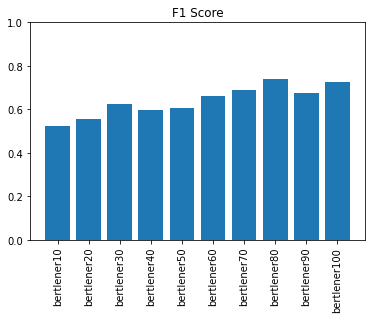

In [36]:
import matplotlib.pyplot as plt
xticks = list(metrics.keys())
print(xticks)
x = list(range(len(xticks)))
print(x)
y = [metrics[x][0]['partial']['f1'] for x in xticks]
print(y)

fig, ax = plt.subplots(1, 1)
ax.bar(x, y)
ax.set_xticks(x)
ax.set_xticklabels(xticks, rotation='vertical')
plt.ylim([0.0, 1])
plt.title("F1 Score")
plt.show()

['bertlener10', 'bertlener20', 'bertlener30', 'bertlener40', 'bertlener50', 'bertlener60', 'bertlener70', 'bertlener80', 'bertlener90', 'bertlener100']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0.41466131907308373, 0.4456509183319857, 0.5292347377472055, 0.4953453128382767, 0.501645670184996, 0.5707246052189494, 0.6036187670944667, 0.6591407277509864, 0.5788027243398256, 0.6426184165033998]


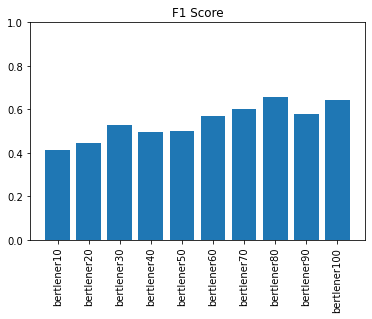

In [37]:
import matplotlib.pyplot as plt
xticks = list(metrics.keys())
print(xticks)
x = list(range(len(xticks)))
print(x)
y = [metrics[x][0]['strict']['f1'] for x in xticks]
print(y)

fig, ax = plt.subplots(1, 1)
ax.bar(x, y)
ax.set_xticks(x)
ax.set_xticklabels(xticks, rotation='vertical')
plt.ylim([0.0, 1])
plt.title("F1 Score")
plt.show()

['bertlener10', 'bertlener20', 'bertlener30', 'bertlener40', 'bertlener50', 'bertlener60', 'bertlener70', 'bertlener80', 'bertlener90', 'bertlener100']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0.6165329768270945, 0.6524200069308075, 0.6971195184866723, 0.6713574366746049, 0.6973101804562479, 0.7456602083100011, 0.75131495897328, 0.8097325734327048, 0.7563627673557175, 0.794053244208828]


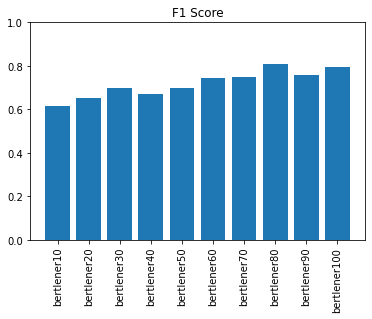

In [38]:
import matplotlib.pyplot as plt
xticks = list(metrics.keys())
print(xticks)
x = list(range(len(xticks)))
print(x)
y = [metrics[x][0]['ent_type']['f1'] for x in xticks]
print(y)

fig, ax = plt.subplots(1, 1)
ax.bar(x, y)
ax.set_xticks(x)
ax.set_xticklabels(xticks, rotation='vertical')
plt.ylim([0.0, 1])
plt.title("F1 Score")
plt.show()

['bertlener10', 'bertlener20', 'bertlener30', 'bertlener40', 'bertlener50', 'bertlener60', 'bertlener70', 'bertlener80', 'bertlener90', 'bertlener100']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0.41844919786096263, 0.44819221439297674, 0.5331040412725709, 0.5011907339250921, 0.5043695380774033, 0.5731884869526264, 0.606564275194614, 0.6615519508987285, 0.5811924961166209, 0.6446928661979946]


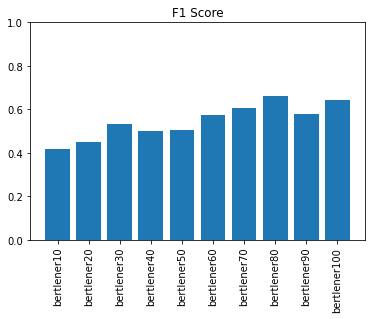

In [39]:
import matplotlib.pyplot as plt
xticks = list(metrics.keys())
print(xticks)
x = list(range(len(xticks)))
print(x)
y = [metrics[x][0]['exact']['f1'] for x in xticks]
print(y)

fig, ax = plt.subplots(1, 1)
ax.bar(x, y)
ax.set_xticks(x)
ax.set_xticklabels(xticks, rotation='vertical')
plt.ylim([0.0, 1])
plt.title("F1 Score")
plt.show()

### test 2


['bertlener10', 'bertlener20', 'bertlener30', 'bertlener40', 'bertlener50', 'bertlener60', 'bertlener70', 'bertlener80', 'bertlener90', 'bertlener100']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109]
[0.4265060240963856, 0.4289906103286385, 0.6600441501103753, 0.7120954003407155, 0.9204389574759946, 0.23877551020408164, 0.9179415855354659, 0.6991304347826086, 0.47897196261682246, 0.6864864864864865, 0.3501762632197415, 0.38107416879795397, 0.42708968883465526, 0.7274633123689727, 0.7446102819237147, 0.877318116975749, 0.33333333333333337, 0.9439124487004102, 0.7873376623376622, 0.637295081967213, 0.6

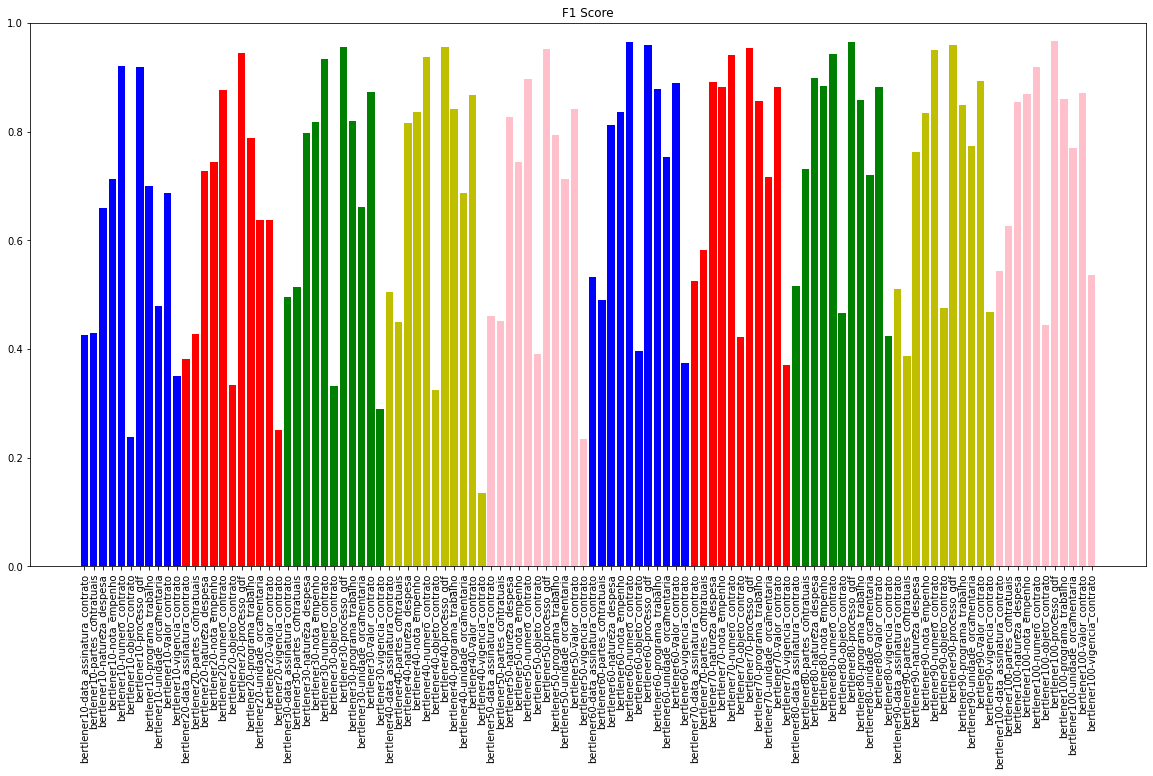

In [40]:
import matplotlib.pyplot as plt
xticks = list(metrics.keys())
print(xticks)
x = list(range(len(xticks) * len(entidadesExtratoContrato)))
print(x)
y = [metrics[x][1][ent]['partial']['f1'] for x in xticks for ent in entidadesExtratoContrato]
print(y)

labels = [i+'-'+j for i in xticks for j in entidadesExtratoContrato]

colors = ['b']*11 +['r']*11 +['g']*11 +['y']*11 + ['pink']*11 + ['b']*11 +['r']*11 +['g']*11 +['y']*11 + ['pink']*11

fig, ax = plt.subplots(1, 1,figsize=(20, 10))
ax.bar(x, y, color = colors)
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation='vertical')
plt.ylim([0.0, 1])
plt.title("F1 Score")

plt.show()

['bertlener10', 'bertlener20', 'bertlener30', 'bertlener40', 'bertlener50', 'bertlener60', 'bertlener70', 'bertlener80', 'bertlener90', 'bertlener100']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109]
[0.4265060240963856, 0.4289906103286385, 0.6600441501103753, 0.7120954003407155, 0.9204389574759946, 0.23877551020408164, 0.9179415855354659, 0.6991304347826086, 0.47897196261682246, 0.6864864864864865, 0.3501762632197415, 0.38107416879795397, 0.42708968883465526, 0.7274633123689727, 0.7446102819237147, 0.877318116975749, 0.33333333333333337, 0.9439124487004102, 0.7873376623376622, 0.637295081967213, 0.6

Text(0.5, 1.0, 'F1 Score')

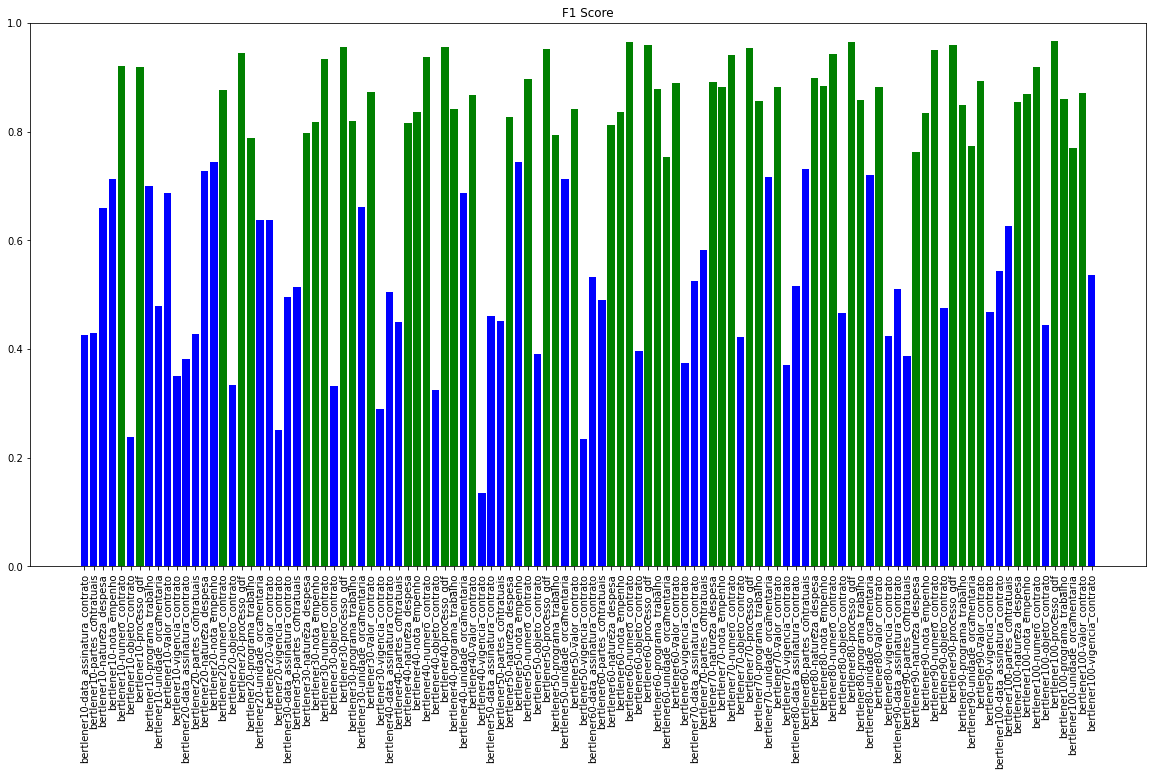

In [41]:
import matplotlib.pyplot as plt
xticks = list(metrics.keys())
print(xticks)
x = list(range(len(xticks) * len(entidadesExtratoContrato)))
print(x)
y = [metrics[x][1][ent]['partial']['f1'] for x in xticks for ent in entidadesExtratoContrato]
print(y)

labels = [i+'-'+j for i in xticks for j in entidadesExtratoContrato]

colors = ['b']*110

l_best = []
for i in range(len(y)):
  if y[i]>0.75:
    colors[i]='g'
    l_best.append(labels[i])
print(l_best)

fig, ax = plt.subplots(1, 1,figsize=(20, 10))
ax.bar(x, y, color = colors)
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation='vertical')
plt.ylim([0.0, 1])
plt.title("F1 Score")


['bertlener10', 'bertlener20', 'bertlener30', 'bertlener40', 'bertlener50', 'bertlener60', 'bertlener70', 'bertlener80', 'bertlener90', 'bertlener100']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0.5247326203208557, 0.5576989719302299, 0.6231728288907997, 0.5956917081619398, 0.6073090455112927, 0.6641281218501512, 0.6879865348201136, 0.7421087242437527, 0.6742741068227983, 0.724328685029388]


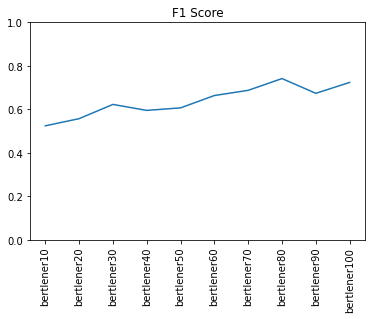

In [42]:
import matplotlib.pyplot as plt
xticks = list(metrics.keys())
print(xticks)
x = list(range(len(xticks)))
print(x)
y = [metrics[x][0]['partial']['f1'] for x in xticks]
print(y)


fig, ax = plt.subplots(1, 1)
ax.plot(y) # adincionar linha
ax.set_xticks(x)
ax.set_xticklabels(xticks, rotation='vertical')
plt.ylim([0.0, 1])
plt.title("F1 Score")
plt.show()

['bertlener10', 'bertlener20', 'bertlener30', 'bertlener40', 'bertlener50', 'bertlener60', 'bertlener70', 'bertlener80', 'bertlener90', 'bertlener100']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0.41466131907308373, 0.4456509183319857, 0.5292347377472055, 0.4953453128382767, 0.501645670184996, 0.5707246052189494, 0.6036187670944667, 0.6591407277509864, 0.5788027243398256, 0.6426184165033998]


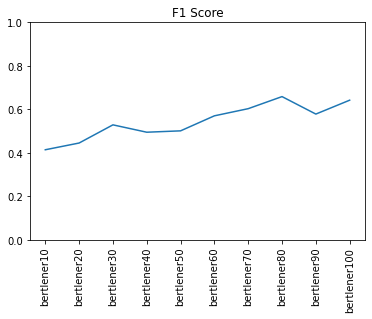

In [43]:
import matplotlib.pyplot as plt
xticks = list(metrics.keys())
print(xticks)
x = list(range(len(xticks)))
print(x)
y = [metrics[x][0]['strict']['f1'] for x in xticks]
print(y)


fig, ax = plt.subplots(1, 1)
ax.plot(y) # adincionar linha
ax.set_xticks(x)
ax.set_xticklabels(xticks, rotation='vertical')
plt.ylim([0.0, 1])
plt.title("F1 Score")
plt.show()